In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip /content/drive/MyDrive/jpeg-224x224.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/wild pansy/4315.jpeg  
  inflating: train/wild pansy/4350.jpeg  
  inflating: train/wild pansy/4591.jpeg  
  inflating: train/wild pansy/4778.jpeg  
  inflating: train/wild pansy/4961.jpeg  
  inflating: train/wild pansy/5032.jpeg  
  inflating: train/wild pansy/5083.jpeg  
  inflating: train/wild pansy/5136.jpeg  
  inflating: train/wild pansy/514.jpeg  
  inflating: train/wild pansy/5142.jpeg  
  inflating: train/wild pansy/5193.jpeg  
  inflating: train/wild pansy/5248.jpeg  
  inflating: train/wild pansy/5284.jpeg  
  inflating: train/wild pansy/5307.jpeg  
  inflating: train/wild pansy/5455.jpeg  
  inflating: train/wild pansy/5584.jpeg  
  inflating: train/wild pansy/5705.jpeg  
  inflating: train/wild pansy/5787.jpeg  
  inflating: train/wild pansy/5963.jpeg  
  inflating: train/wild pansy/6043.jpeg  
  inflating: train/wild pansy/6069.jpeg  
  inflating: train/wild pansy/6075.jpeg  
  inflating: train/wild pa

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
import pathlib
data_train = pathlib.Path("/content/train")
data_val = pathlib.Path("/content/val")
data_test = pathlib.Path("/content/test")

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2)

In [8]:
train_generator = train_datagen.flow_from_directory('/content/train',
                                                   target_size=(224,224),
                                                   batch_size=16,
                                                   seed=12345,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 12753 images belonging to 104 classes.


In [9]:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [10]:
validation_generator = val_datagen.flow_from_directory('/content/val',
                                                      target_size=(224, 224),
                                                      batch_size=16,
                                                      shuffle=False,
                                                      class_mode='categorical')

Found 3712 images belonging to 104 classes.


In [11]:
early_stop = keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10, monitor='val_loss')

In [12]:
def model_maker():
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    inp = keras.layers.Input(shape=(224,224,3))
    custom_model = base_model(inp)
    custom_model = keras.layers.GlobalAveragePooling2D()(custom_model)
    custom_model = keras.layers.Dense(64, activation='relu')(custom_model)
    custom_model = keras.layers.Dropout(0.5)(custom_model)
    output = keras.layers.Dense(104, activation='softmax')(custom_model)
    model = keras.Model(inputs=inp, outputs=output)
    return model


In [13]:
model = model_maker()

94781440/94765736 [==============================] - 1s 0us/step


In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [15]:
r = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/100
798/798 [==============================] - 262s 285ms/step - loss: 3.4939 - acc: 0.2132 - val_loss: 2.3434 - val_acc: 0.4254
Epoch 2/100
798/798 [==============================] - 223s 280ms/step - loss: 2.7498 - acc: 0.3158 - val_loss: 1.8233 - val_acc: 0.5482
Epoch 3/100
798/798 [==============================] - 223s 280ms/step - loss: 2.4619 - acc: 0.3631 - val_loss: 1.5669 - val_acc: 0.6078
Epoch 4/100
798/798 [==============================] - 221s 277ms/step - loss: 2.3218 - acc: 0.3870 - val_loss: 1.4423 - val_acc: 0.6320
Epoch 5/100
798/798 [==============================] - 221s 276ms/step - loss: 2.2103 - acc: 0.4059 - val_loss: 1.3990 - val_acc: 0.6455
Epoch 6/100
798/798 [==============================] - 220s 276ms/step - loss: 2.1755 - acc: 0.4170 - val_loss: 1.2924 - val_acc: 0.6627
Epoch 7/100
798/798 [==============================] - 220s 275ms/step - loss: 2.1138 - acc: 0.4253 - val_loss: 1.2272 - val_acc: 0.6813
Epoch 8/100
798/798 [====================

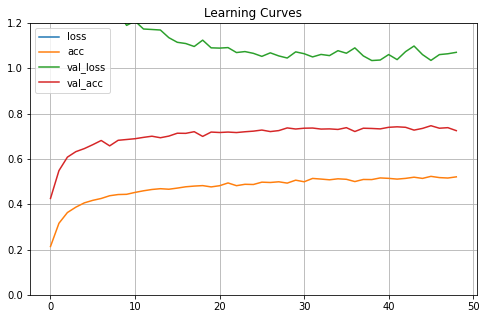

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(r.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Learning Curves')
plt.gca().set_ylim(0,1.2)
plt.show()